In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2

# **Visualizing Classes**

In [3]:
train_dir = '../input/fer2013/train/'
test_dir = '../input/fer2013/test/'

def Classes_Count( path, name):
    Classes_Dict = {}
    
    for Class in os.listdir(path):
        
        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))
        
    df = pd.DataFrame(Classes_Dict, index=[name])
    
    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

In [4]:
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


<AxesSubplot:>

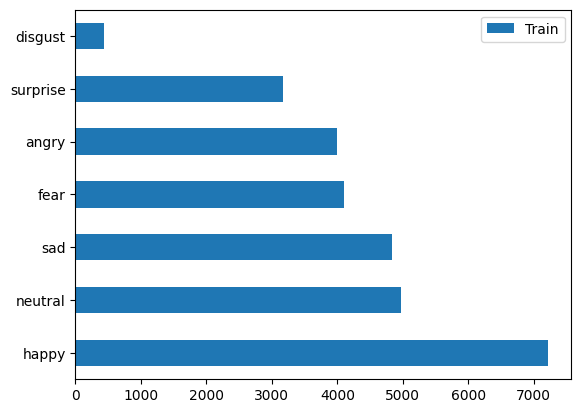

In [5]:
Train_Count.plot(kind='barh')

<AxesSubplot:>

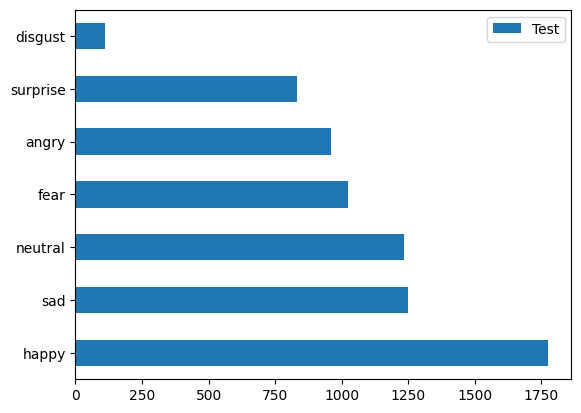

In [6]:
Test_Count.plot(kind='barh')

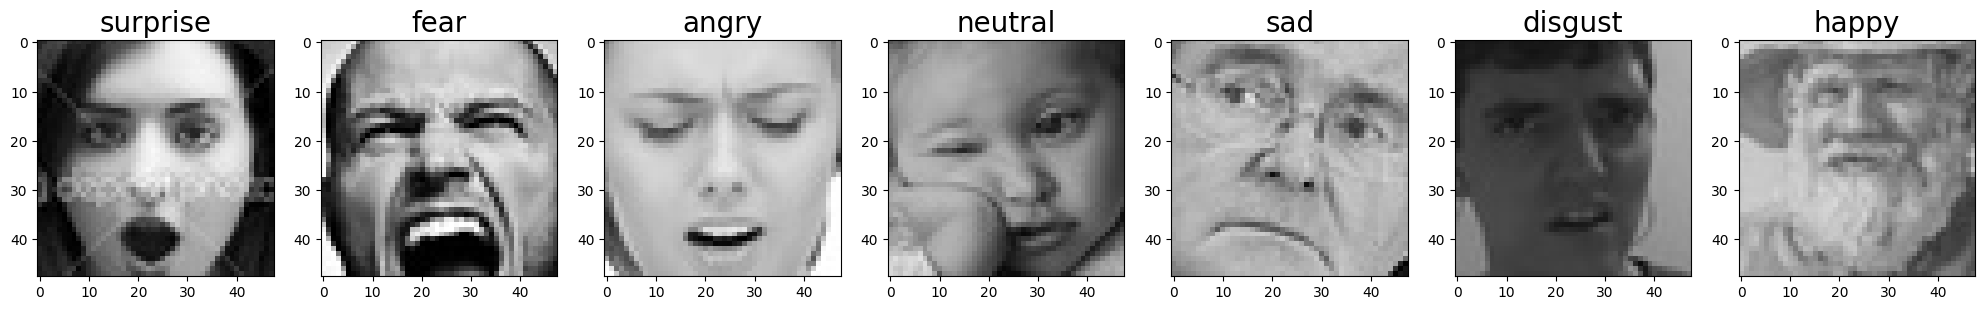

In [7]:
plt.style.use('default')
plt.figure(figsize = (25, 8))
image_count = 1
BASE_URL = '../input/fer2013/train/'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize = 20)

# **Data Preprocessing**

In [8]:
img_shape = 48
batch_size = 64
train_data_path = '../input/fer2013/train/'
test_data_path = '../input/fer2013/test/'

In [9]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        # Data Augmentation
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)


test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **Building CNN Model**

In [10]:
def Create_CNN_Model():
    
    model = Sequential()
    
    #CNN1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_shape, img_shape, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    #CNN2
    model.add(Conv2D(64, (3,3), activation='relu', ))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    #CNN3
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    
    #Output
    model.add(Flatten())
    
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(7,activation='softmax'))
    
    
    return model

In [11]:
CNN_Model = Create_CNN_Model()

CNN_Model.summary()

CNN_Model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        3

**Specifying Callbacks**

In [12]:
# Create Callback Checkpoint
checkpoint_path = "CNN_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.000005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [13]:
CNN_history = CNN_Model.fit( train_data , validation_data= test_data , epochs=50, batch_size= batch_size,
                            callbacks=callbacks, steps_per_epoch= steps_per_epoch, validation_steps=validation_steps)

Epoch 1/50
448/448 [==============================] - 150s 317ms/step - loss: 2.0302 - accuracy: 0.2067 - val_loss: 1.8320 - val_accuracy: 0.2444
Epoch 2/50
448/448 [==============================] - 55s 123ms/step - loss: 1.7918 - accuracy: 0.2662 - val_loss: 1.6283 - val_accuracy: 0.3422
Epoch 3/50
448/448 [==============================] - 56s 126ms/step - loss: 1.6573 - accuracy: 0.3389 - val_loss: 1.5259 - val_accuracy: 0.4053
Epoch 4/50
448/448 [==============================] - 58s 130ms/step - loss: 1.5312 - accuracy: 0.4015 - val_loss: 1.3795 - val_accuracy: 0.4667
Epoch 5/50
448/448 [==============================] - 56s 126ms/step - loss: 1.4370 - accuracy: 0.4465 - val_loss: 1.4790 - val_accuracy: 0.4350
Epoch 6/50
448/448 [==============================] - 56s 126ms/step - loss: 1.3726 - accuracy: 0.4768 - val_loss: 1.2983 - val_accuracy: 0.5042
Epoch 7/50
448/448 [==============================] - 56s 125ms/step - loss: 1.3259 - accuracy: 0.4996 - val_loss: 1.2020 - val_a

# **Evaluating CNN Model**

In [14]:
CNN_Score = CNN_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(CNN_Score[0]))
print("Test Accuracy: {:.2f}%".format(CNN_Score[1] * 100))

113/113 [==============================] - 7s 60ms/step - loss: 0.9321 - accuracy: 0.6514
    Test Loss: 0.93211
Test Accuracy: 65.14%


In [15]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()
  
  #plt.tight_layout()

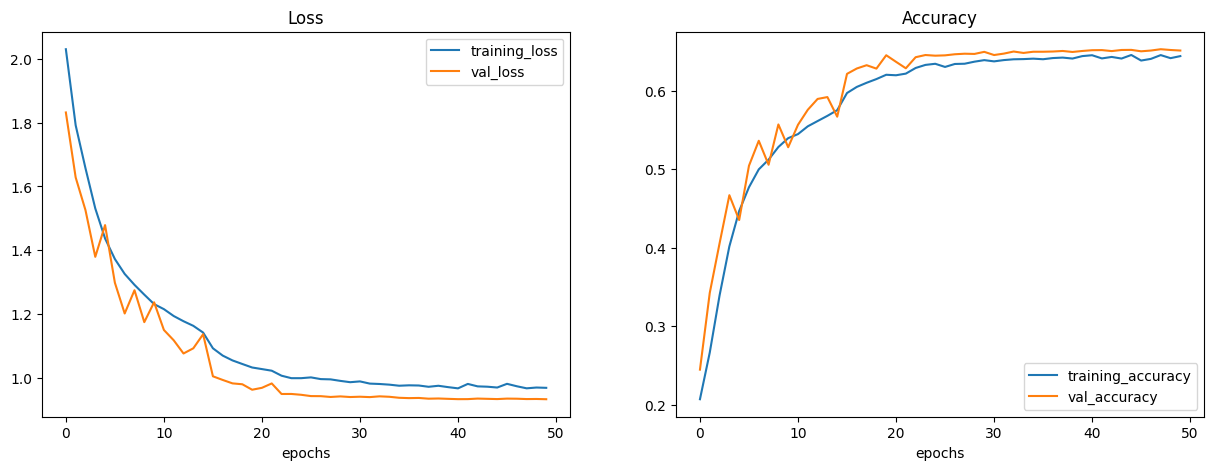

In [16]:
plot_curves(CNN_history)

In [17]:
CNN_Predictions = CNN_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

In [18]:
test_data.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

Text(0.5, 1.0, 'CNN Confusion Matrix')

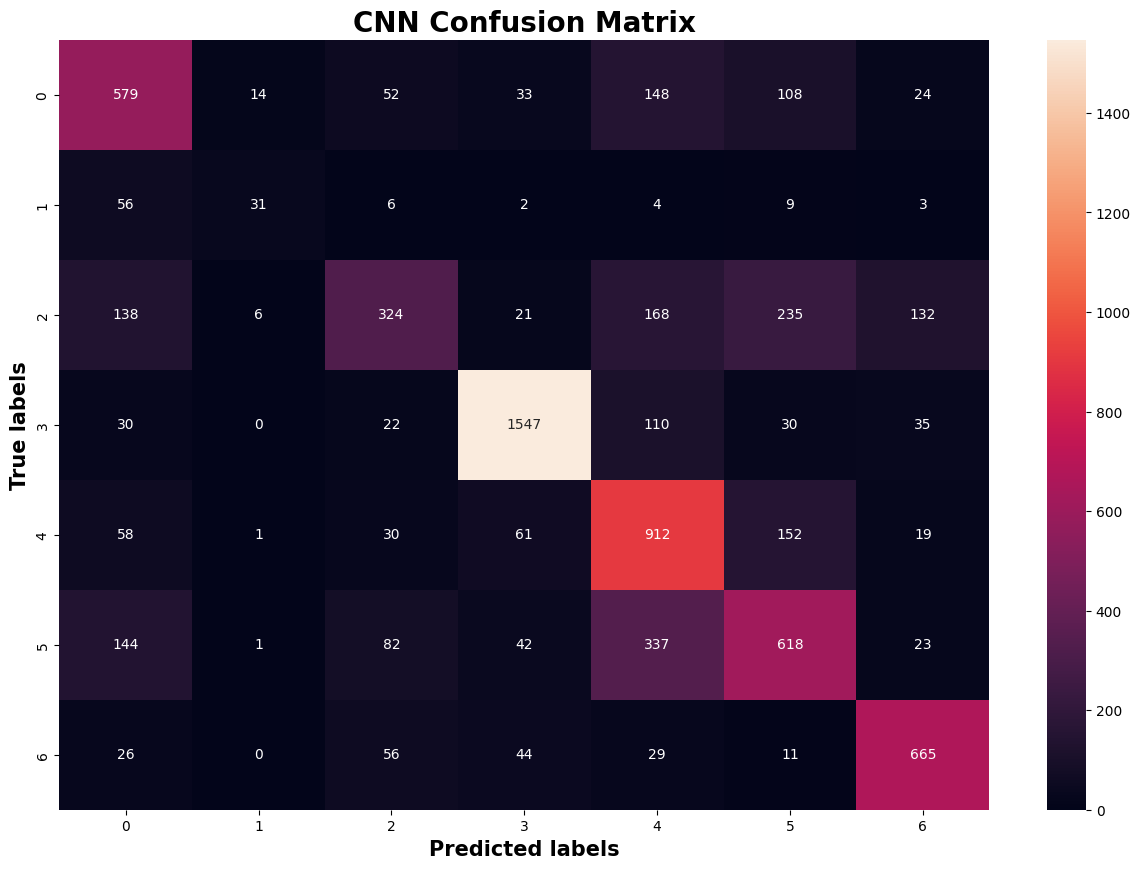

In [19]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, CNN_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

# **ResNet50V2 Model**

In [20]:
# specifing new image shape for resnet
img_shape = 224
batch_size = 64
train_data_path = '../input/fer2013/train/'
test_data_path = '../input/fer2013/test/'

In [21]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **Fine-Tuning ResNet50V2**

In [22]:
# 224,224,3
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

#ResNet50V2.summary()

94683136/94668760 [==============================] - 1s 0us/step


In [23]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [24]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(7,activation='softmax')
                    ])
    return model

In [25]:
ResNet50V2_Model = Create_ResNet50V2_Model()

ResNet50V2_Model.summary()

ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 7, 2048)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 7, 7, 2048)        8192      
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                6422592   
_________________________________________________________________
batch_normalization_13 (Batc (None, 64)                256       
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)               

**Specifying Callbacks**

In [26]:
# Create Callback Checkpoint
checkpoint_path = "ResNet50V2_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.00005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [27]:
ResNet50V2_history = ResNet50V2_Model.fit(train_data ,validation_data = test_data , epochs=30, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/30
448/448 [==============================] - 357s 788ms/step - loss: 1.5578 - accuracy: 0.4802 - val_loss: 1.3975 - val_accuracy: 0.5421
Epoch 2/30
448/448 [==============================] - 353s 788ms/step - loss: 1.2338 - accuracy: 0.5566 - val_loss: 1.1183 - val_accuracy: 0.5707
Epoch 3/30
448/448 [==============================] - 357s 796ms/step - loss: 1.1149 - accuracy: 0.5978 - val_loss: 1.1157 - val_accuracy: 0.5981
Epoch 4/30
448/448 [==============================] - 353s 789ms/step - loss: 1.0704 - accuracy: 0.6130 - val_loss: 1.0251 - val_accuracy: 0.6243
Epoch 5/30
448/448 [==============================] - 352s 786ms/step - loss: 1.0228 - accuracy: 0.6277 - val_loss: 1.0061 - val_accuracy: 0.6360
Epoch 6/30
448/448 [==============================] - 355s 792ms/step - loss: 1.0153 - accuracy: 0.6355 - val_loss: 1.1218 - val_accuracy: 0.6394
Epoch 7/30
448/448 [==============================] - 351s 783ms/step - loss: 0.9895 - accuracy: 0.6423 - val_loss: 1.0390 -

# **Evaluating ResNet50V2**

In [28]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

113/113 [==============================] - 15s 133ms/step - loss: 0.8942 - accuracy: 0.6863
    Test Loss: 0.89415
Test Accuracy: 68.63%


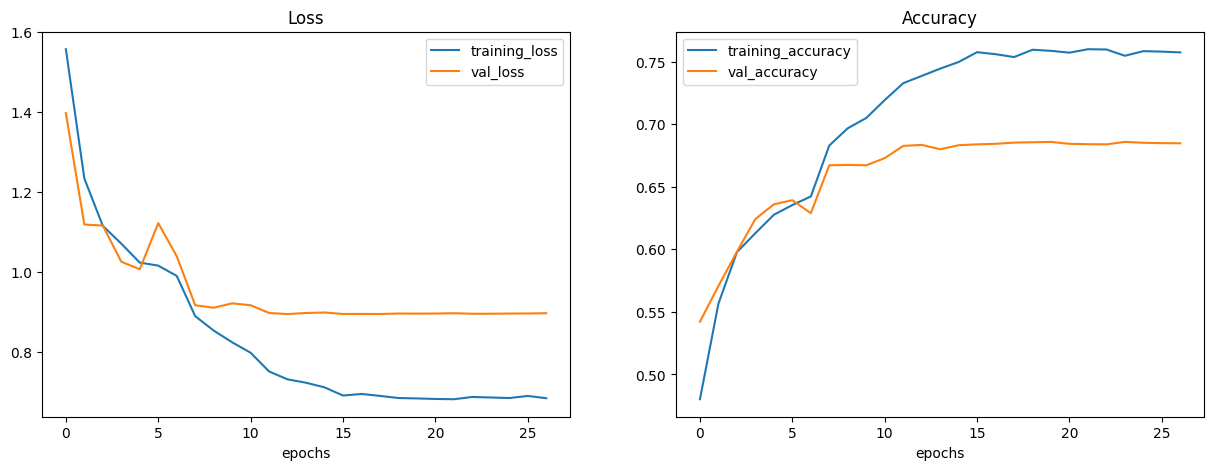

In [29]:
plot_curves(ResNet50V2_history)

In [30]:
ResNet50V2_Predictions = ResNet50V2_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)

Text(0.5, 1.0, 'ResNet50V2 Confusion Matrix')

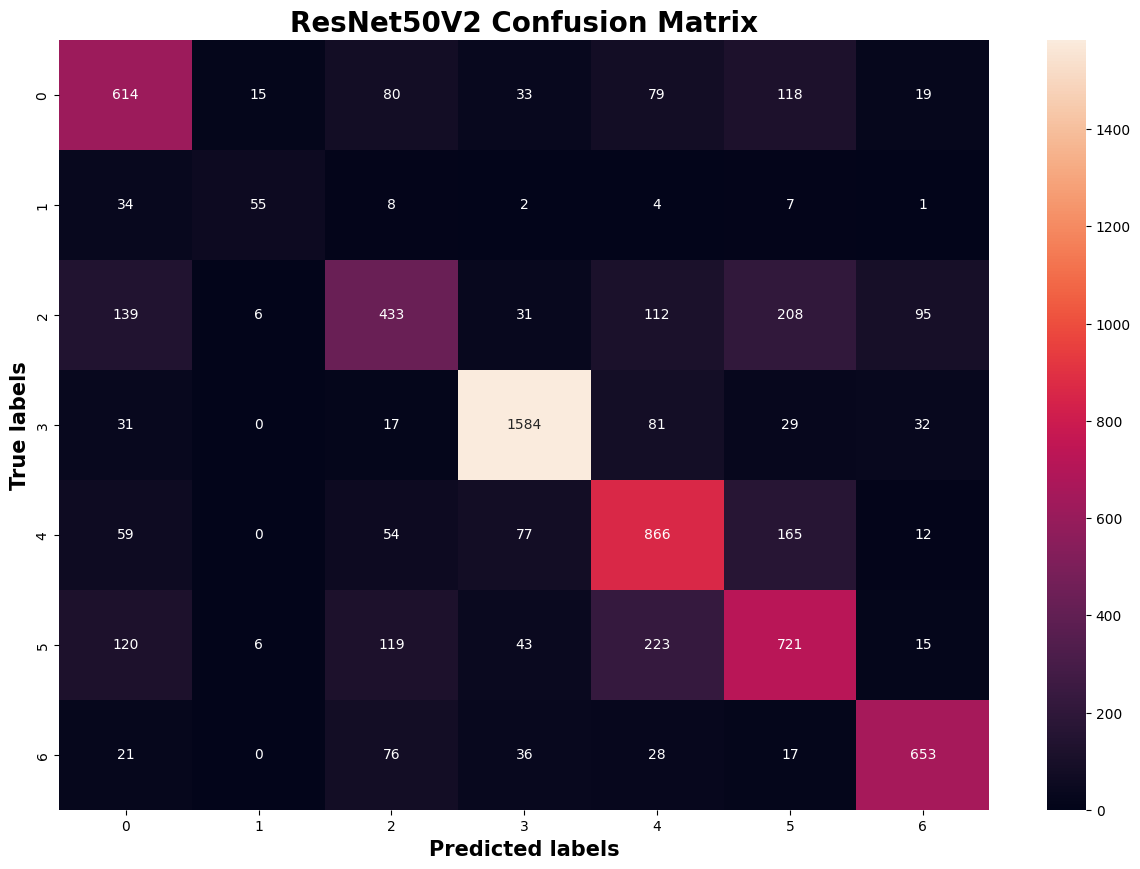

In [31]:
fig , ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, ResNet50V2_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('ResNet50V2 Confusion Matrix', fontsize=20, fontweight='bold')

# **Visualizing Predictions**

In [32]:
Emotion_Classes = ['Angry', 
                  'Disgust', 
                  'Fear', 
                  'Happy', 
                  'Neutral', 
                  'Sad', 
                  'Surprise']

In [33]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


**CNN Predictions**

ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/sequential.py:369 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:415 call
        inputs, training=training, mask=mask)
    /opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.7/site-packages/keras/engine/input_spec.py:254 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer dense is incompatible with the layer: expected axis -1 of input shape to have value 6400 but received input with shape (None, 186624)


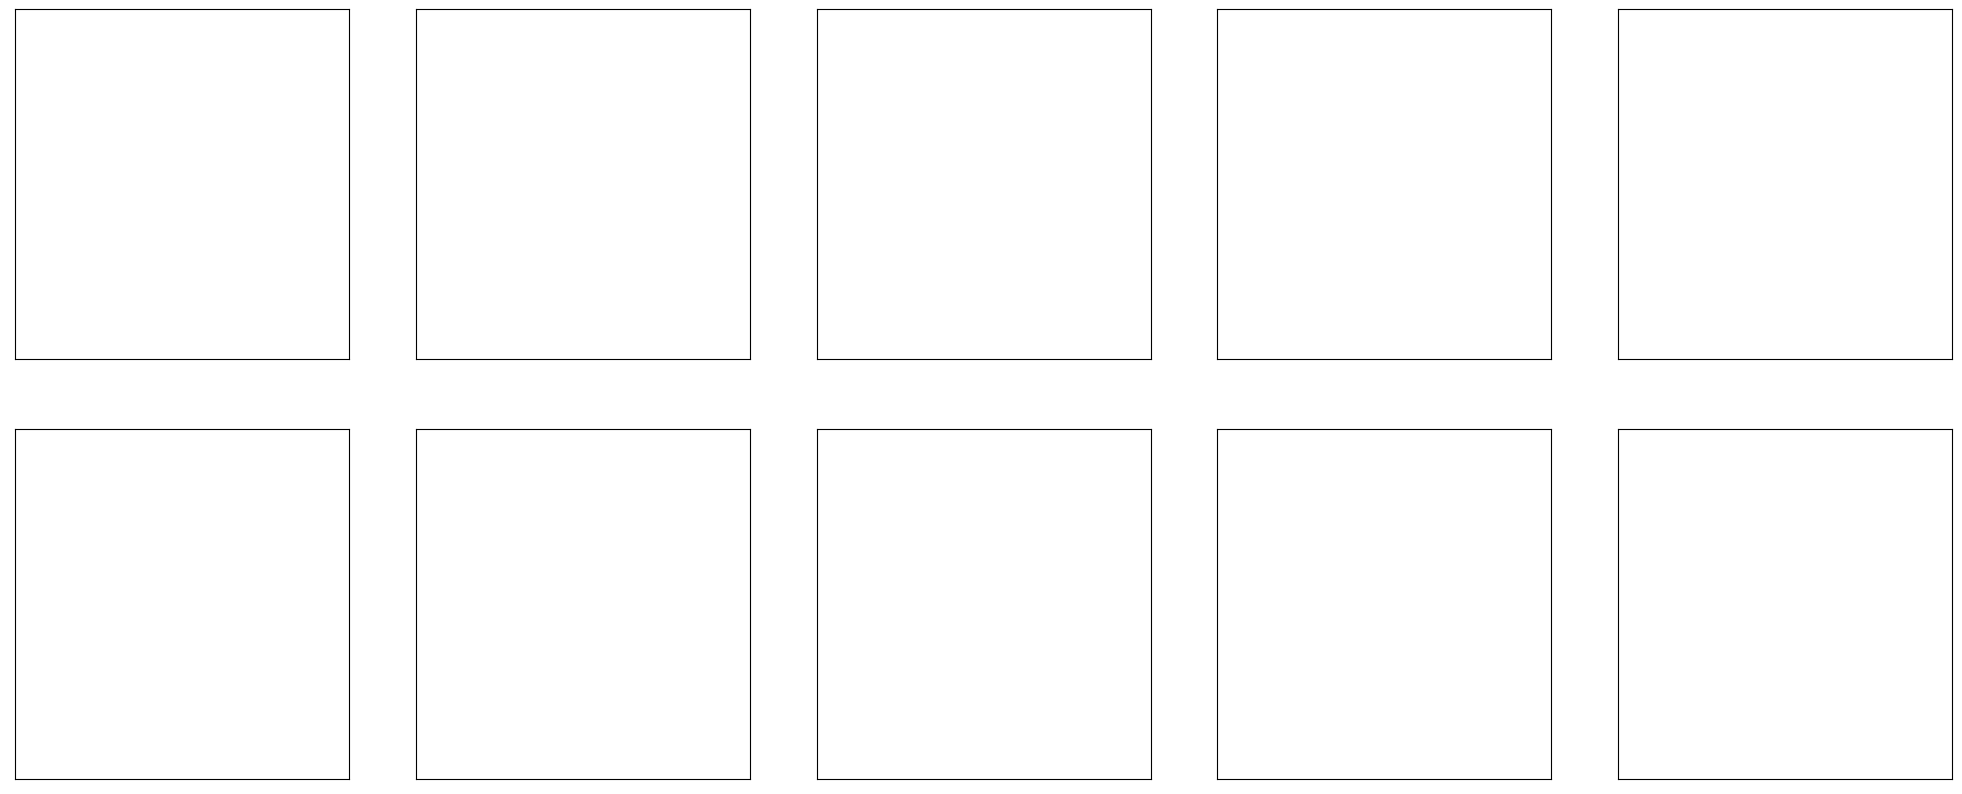

In [34]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(CNN_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

**ResNet50V2 Predictions**

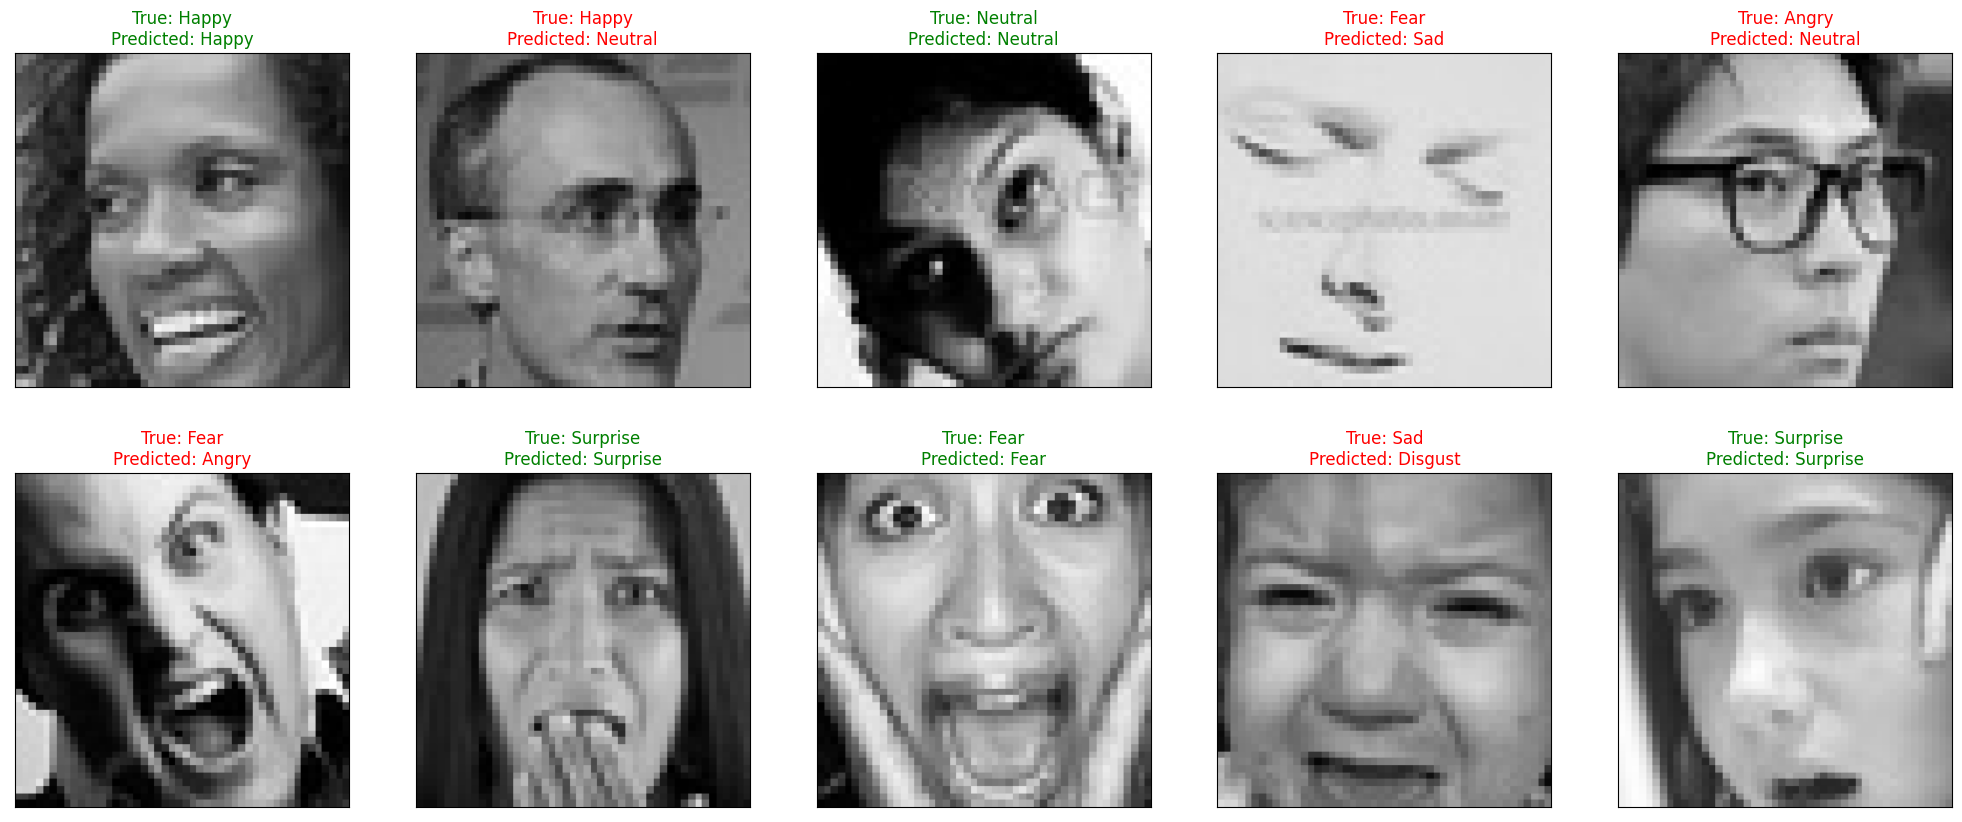

<Figure size 640x480 with 0 Axes>

In [35]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(ResNet50V2_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

# **Music Player**

In [36]:
Music_Player = pd.read_csv("../input/spotify-music-data-to-identify-the-moods/data_moods.csv")
Music_Player = Music_Player[['name','artist','mood','popularity']]
Music_Player.head()

,name,artist,mood,popularity
0,1999,Prince,Happy,68
1,23,Blonde Redhead,Sad,43
2,9 Crimes,Damien Rice,Sad,60
3,99 Luftballons,Nena,Happy,2
4,A Boy Brushed Red Living In Black And White,Underoath,Energetic,60


In [37]:
Music_Player["mood"].value_counts()

Sad          197
Calm         195
Energetic    154
Happy        140
Name: mood, dtype: int64

In [38]:
Music_Player["popularity"].value_counts()

0     92
51    23
52    22
50    21
55    21
      ..
80     1
2      1
14     1
15     1
88     1
Name: popularity, Length: 83, dtype: int64

In [39]:
Play = Music_Player[Music_Player['mood'] =='Calm' ]
Play = Play.sort_values(by="popularity", ascending=False)
Play = Play[:5].reset_index(drop=True)
display(Play)

,name,artist,mood,popularity
0,Lost,Annelie,Calm,64
1,Curiosity,Beau Projet,Calm,60
2,Escaping Time,Benjamin Martins,Calm,60
3,Just Look at You,369,Calm,59
4,Vague,Amaranth Cove,Calm,59


In [41]:
# Making Songs Recommendations Based on Predicted Class
def Recommend_Songs(pred_class):
    
    if( pred_class=='Disgust' ):

        Play = Music_Player[Music_Player['mood'] =='Sad' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Happy' or pred_class=='Sad' ):

        Play = Music_Player[Music_Player['mood'] =='Happy' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Fear' or pred_class=='Angry' ):

        Play = Music_Player[Music_Player['mood'] =='Calm' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Surprise' or pred_class=='Neutral' ):

        Play = Music_Player[Music_Player['mood'] =='Energetic' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

# **Predicting New Images**

**Downloading OpenCV haarcascade frontalface Detection**

In [42]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
    
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")    

--2024-04-27 12:14:51--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.04s   

2024-04-27 12:14:51 (23.5 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [43]:
def load_and_prep_image(filename, img_shape = 224):

    img = cv2.imread(filename)

    GrayImg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    faces = faceCascade.detectMultiScale(GrayImg, 1.1, 4)
    
    for x,y,w,h in faces:
        
        roi_GrayImg = GrayImg[ y: y + h , x: x + w ]
        roi_Img = img[ y: y + h , x: x + w ]
        
        cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)
        
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        
        faces = faceCascade.detectMultiScale(roi_Img, 1.1, 4)
        
        if len(faces) == 0:
            print("No Faces Detected")
        else:
            for (ex, ey, ew, eh) in faces:
                img = roi_Img[ ey: ey+eh , ex: ex+ew ]
    
    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    RGBImg= cv2.resize(RGBImg,(img_shape,img_shape))

    RGBImg = RGBImg/255.

    return RGBImg

In [44]:
def pred_and_plot(filename, class_names):

    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = ResNet50V2_Model.predict(np.expand_dims(img, axis=0))

    # Get the predicted class
    pred_class = class_names[pred.argmax()]

    # Plot the image and predicted class
    #plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);
    
    Recommend_Songs(pred_class)

,name,artist,mood,popularity
0,Pumped Up Kicks,Foster The People,Happy,84
1,Africa,TOTO,Happy,84
2,Take on Me,a-ha,Happy,84
3,Highway to Hell,AC/DC,Happy,83
4,Here Comes The Sun - Remastered 2009,The Beatles,Happy,83


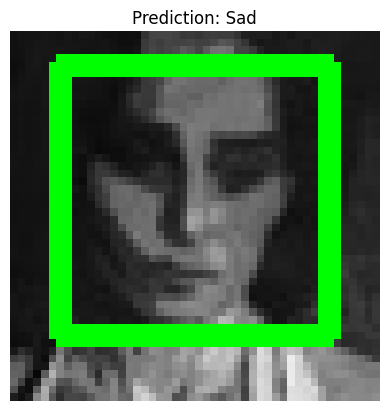

In [45]:
pred_and_plot("../input/fer2013/test/sad/PrivateTest_13472479.jpg", Emotion_Classes) # with CNN

In [46]:
# Downloading Image to Test On
!wget -c "https://pbs.twimg.com/media/EEY3RFFWwAAc-qm.jpg" -O sad.jpg

--2024-04-27 12:15:51--  https://pbs.twimg.com/media/EEY3RFFWwAAc-qm.jpg
Resolving pbs.twimg.com (pbs.twimg.com)... 72.21.91.70, 2606:2800:220:1410:489:141e:20bb:12f6
Connecting to pbs.twimg.com (pbs.twimg.com)|72.21.91.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36922 (36K) [image/jpeg]
Saving to: ‘sad.jpg’

sad.jpg             100%[===================>]  36.06K  --.-KB/s    in 0.006s  

2024-04-27 12:15:51 (6.36 MB/s) - ‘sad.jpg’ saved [36922/36922]



In [47]:
pred_and_plot("./happy.jpg", Emotion_Classes) # with CNN

error: OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


,name,artist,mood,popularity
0,Lost,Annelie,Calm,64
1,Curiosity,Beau Projet,Calm,60
2,Escaping Time,Benjamin Martins,Calm,60
3,Just Look at You,369,Calm,59
4,Vague,Amaranth Cove,Calm,59


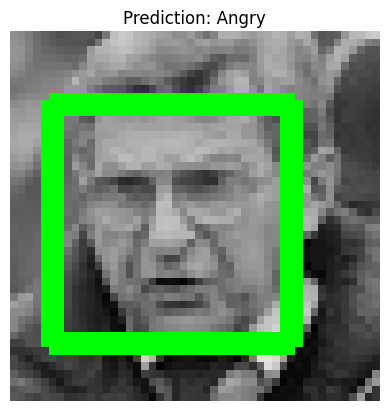

In [48]:
pred_and_plot("../input/fer2013/test/angry/PrivateTest_22126718.jpg", Emotion_Classes) # with ResNet50V2

In [ ]:
# Downloading Image to Test On
!wget -c "https://pbs.twimg.com/profile_images/758370732413947904/xYB5Q3FY_400x400.jpg" -O happy.jpg 

In [ ]:
pred_and_plot("./sad.jpg", Emotion_Classes) # with ResNet50V2

In [49]:
CNN_Model.save("CNN_Model.h5")

ResNet50V2_Model.save("ResNet50V2_Model.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
